# Dynamic properties of FCC-Al

This example demonstrate the analysis of the dynamics of crystalline aluminium in the face-centered cubic (FCC) structure via the dynamic structure factor as well as current correlation functions.
Here, we use a rather small simulation cell (i.e., few **q**-points) and a short trajectory in order to make the tutorial run fast.
In practice one needs to tune these parameters as well as the parameters used when calling **dynasor** for optimal results.

This example uses a trajectory that can be downloaded from zenodo via
```bash
wget https://zenodo.org/records/10014454/files/dumpT300.NVT.atom.velocity.gz
```
or generated from scratch by running **lammps** using the input files provided.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.build import bulk
from dynasor import compute_dynamic_structure_factors, Trajectory
from dynasor.qpoints import get_supercell_qpoints_along_path
from seekpath import get_path

## Set up the Trajectory

**dynasor** supports multiple different trajectory formats via internal readers as well as via [mdanalysis](https://www.mdanalysis.org/) and [ase](https://wiki.fysik.dtu.dk/ase/).
Here, we use the internal lammps reader.

In [2]:
trajectory_filename = 'dumpT300.NVT.atom.velocity.gz'
traj = Trajectory(trajectory_filename,
                  trajectory_format='lammps_internal', frame_stop=10000)

INFO: Trajectory file: dumpT300.NVT.atom.velocity.gz
INFO: Total number of particles: 6912
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 6912
INFO: Simulation cell (in Angstrom):
[[48.78  0.    0.  ]
 [ 0.   48.78  0.  ]
 [ 0.    0.   48.78]]


A short summary of the content of the `traj` object can be obtained via the `display` (in notebooks) or `print` (in notebooks or scripts) command.

In [3]:
display(traj)

## Set up path through Brillouin zone

We now need to define the path through the Brillouin zone that we want to sample.
The latter can be generated automatically for the crystal structure of interest using the [seekpath package](https://seekpath.readthedocs.io/).
To find the q-points along this path that can be sampled using the supercell used in the molecular dynamics simulations we use the function `get_supercell_qpoints_along_path`.

The primitive structure is generate using the [bulk function](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#ase.build.bulk) from the [ase package](https://wiki.fysik.dtu.dk/ase/).

In [4]:
prim = bulk('Al', a=4.065)
path_info = get_path((
    prim.cell,
    prim.get_scaled_positions(),
    prim.numbers))
point_coordinates = path_info['point_coords']
path = path_info['path']
display(point_coordinates)
display(path)

{'GAMMA': [0.0, 0.0, 0.0],
 'X': [0.5, 0.0, 0.5],
 'L': [0.5, 0.5, 0.5],
 'W': [0.5, 0.25, 0.75],
 'W_2': [0.75, 0.25, 0.5],
 'K': [0.375, 0.375, 0.75],
 'U': [0.625, 0.25, 0.625]}

[('GAMMA', 'X'),
 ('X', 'U'),
 ('K', 'GAMMA'),
 ('GAMMA', 'L'),
 ('L', 'W'),
 ('W', 'X')]

In [5]:
q_segments = get_supercell_qpoints_along_path(
    path, point_coordinates, prim.cell, traj.cell)
q_points = np.vstack(q_segments)

## Run calculation of correlation functions

We are now all set for calculating the dynamic structure factor as well as the current correlation functions, where the latter is triggered by setting `include_currents=True`.
To obtain the correct units, the spacing between the frames (`dt`) must be specified in units of femtoseconds.

The following cell should take ten to twenty minutes to run on a common work station.

**Note:**
The `Trajectory` object is an "exhaustible iterable" , which means that once we have iterated over all frames, it is exhausted.
Therefore, one needs to "reload" the trajectory before calling `compute_dynamic_structure_factors` again to ensure that the entire trajectory is available for analysis.

In [6]:
%%time
sample = compute_dynamic_structure_factors(
    traj, q_points, dt=25.0, window_size=500,
    window_step=50, calculate_currents=True)

INFO: Spacing between samples (frame_step): 1
INFO: Time between consecutive frames in input trajectory (dt): 25.0 fs
INFO: Time between consecutive frames used (dt * frame_step): 25.0 fs
INFO: Time window size (dt * frame_step * window_size): 12500.0 fs
INFO: Angular frequency resolution: dw = 0.000503 2pi/fs = 0.331 meV
INFO: Maximum angular frequency (dw * window_size): 0.251327 2pi/fs = 165.427 meV
INFO: Nyquist angular frequency (2pi / frame_step / dt / 2): 0.126 2pi/fs = 82.7 meV
INFO: Calculating current (velocity) correlations
INFO: Number of q-points: 48
CPU times: user 17min 52s, sys: 1.04 s, total: 17min 53s
Wall time: 4min 45s


As in the case of the trajectory, we can use the `display` or `print` commands to obtain a quick summary of the [Sample object](https://dynasor.materialsmodeling.org/sample.html) returned by the [compute_dynamic_structure_factors function](https://dynasor.materialsmodeling.org/interface_python/correlation_functions.html).

In [7]:
display(sample)

DynamicSample
Atom types: ['X']
Pairs: [('X', 'X')]
Particle counts: {'X': 6912}
Simulations cell:
[[48.78  0.    0.  ]
 [ 0.   48.78  0.  ]
 [ 0.    0.   48.78]]
q_points        with shape: (48, 3)
time            with shape: (501,)
omega           with shape: (501,)
Fqt_coh_X_X     with shape: (48, 501)
Sqw_coh_X_X     with shape: (48, 501)
Fqt_coh         with shape: (48, 501)
Sqw_coh         with shape: (48, 501)
Clqt_X_X        with shape: (48, 501)
Ctqt_X_X        with shape: (48, 501)
Clqw_X_X        with shape: (48, 501)
Ctqw_X_X        with shape: (48, 501)
Clqt            with shape: (48, 501)
Ctqt            with shape: (48, 501)
Clqw            with shape: (48, 501)
Ctqw            with shape: (48, 501)
Fqt             with shape: (48, 501)
Sqw             with shape: (48, 501)

To find out which correlation functions are included in a `Sample` object, one can inspect the `available_correlation_functions` property.

**Tip:**
When working with an interactive Python interpreter, e.g., when using `ipython` or a `jupyter` instance, you can hit the `<tab>` key after writing `sample.` to show a list of possible completions.

In [8]:
sample.available_correlation_functions

['Clqt',
 'Clqt_X_X',
 'Clqw',
 'Clqw_X_X',
 'Ctqt',
 'Ctqt_X_X',
 'Ctqw',
 'Ctqw_X_X',
 'Fqt',
 'Fqt_coh',
 'Fqt_coh_X_X',
 'Sqw',
 'Sqw_coh',
 'Sqw_coh_X_X']

One can also write a `Sample` object to file and load it later for further processing.
To write the object one should use the `write_to_npz` method.

In [9]:
sample.write_to_npz('my_sample.npz')

The results can be read from file using the `read_to_npz` function from the `dynasor.sample` module.

## Visualize dynamic structure factor

We can now visualize the dynamic structure factor $S(\mathbf{q}, \omega)$, for example, in the form of a heatmap on the momentum-frequency plane.

In preparation in the following cell, we compute the running pair-wise distance between **q**-points along the path.

In [10]:
q_distances = []
q_labels = dict()

# starting point
qr = 0.0

# collect labels and q-distances along the entire q-point path
for it, q_segment in enumerate(q_segments):
    q_distances.append(qr)
    q_labels[qr] = path[it][0]
    for qi, qj in zip(q_segment[1:], q_segment[:-1]):
        qr += np.linalg.norm(qi - qj)
        q_distances.append(qr)
    
q_labels[qr] = path[-1][1]
q_distances = np.array(q_distances)

We are now ready to plot the dispersion, here the angular frequency $\omega$ is converged to units of meV.    
Note that the dynamic structure factor only contains information about the longitudinal modes.

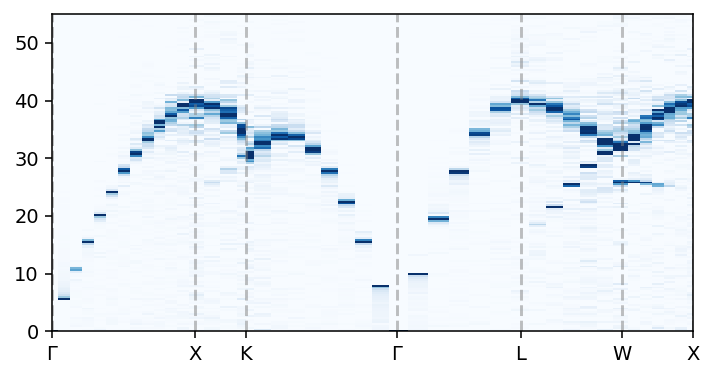

In [11]:
from dynasor.units import radians_per_fs_to_meV as conversion_factor

fig = plt.figure(figsize=(5.2, 2.8), dpi=140)
ax = fig.add_subplot(111)
ax.pcolormesh(q_distances, conversion_factor * sample.omega,
              sample.Sqw_coh.T, cmap='Blues', vmin=0, vmax=4)

xticks = []
xticklabels = []
for q_dist, q_label in q_labels.items():
    ax.axvline(q_dist, c='0.5', alpha=0.5, ls='--')
    xticks.append(q_dist)
    xticklabels.append(q_label.replace('GAMMA', r'$\Gamma$'))

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_xlim([0, q_distances.max()])
ax.set_ylim([0, 55])

fig.tight_layout()

## Visualize current correlations

We can also plot the longitudinal and transverse current correlation heatmaps.
In the longitudinal current correlation function one can observe the longitudinal branch that is also visible in the dynamic structure factor.
The transverse current correlation functions also reveals a transverse mode.
The combination of the two (shown below) thus contains the full dispersion.

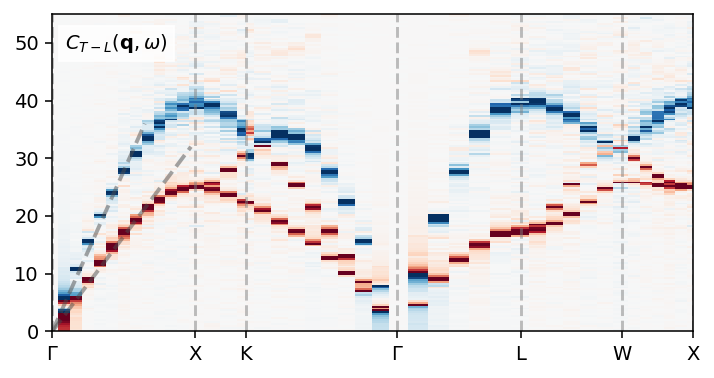

In [12]:
fig = plt.figure(figsize=(5.2, 2.8), dpi=140)
ax = fig.add_subplot(111)
ax.pcolormesh(q_distances, conversion_factor * sample.omega,
              sample.Clqw.T - sample.Ctqw.T,
              cmap='RdBu', vmin=-6000, vmax=6000)

ax.plot([0, 1.0], [0, 36], alpha=0.5, ls='--', c='0.3', lw=2)
ax.plot([0, 1.5], [0, 32], alpha=0.5, ls='--', c='0.3', lw=2)

ax.text(0.02, 0.89, '$C_{T-L}(\mathbf{q}, \omega)$', transform=ax.transAxes,
        bbox={'color': 'white', 'alpha': 0.8, 'pad': 3})

xticks = []
xticklabels = []
for q_dist, q_label in q_labels.items():
    ax.axvline(q_dist, c='0.5', alpha=0.5, ls='--')
    xticks.append(q_dist)
    xticklabels.append(q_label.replace('GAMMA', r'$\Gamma$'))

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_xlim([0, q_distances.max()])
ax.set_ylim([0, 55])

fig.tight_layout()